In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

%matplotlib inline

from session.sessions import selected_009266, selected_009265
from imports import *
from loading import load_session_data

from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
np.set_printoptions(suppress=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Session data

In [3]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [30]:
session = sessions[8]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']

session

'009265_hippoSIT_2023-03-02_09-32-54'

## Metric distributions

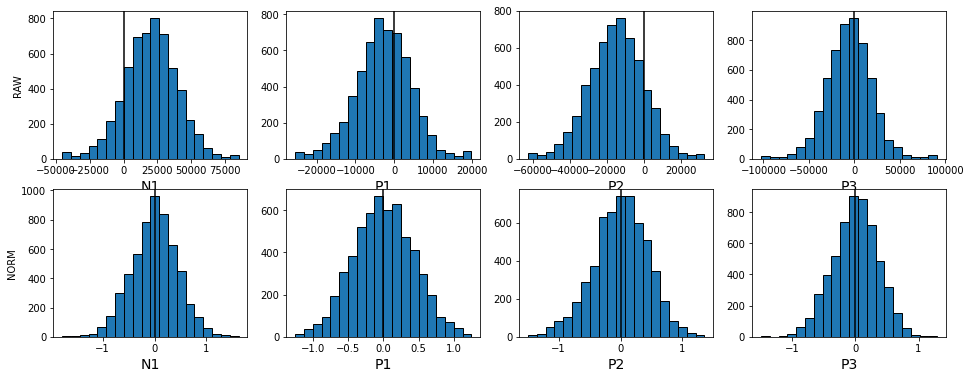

In [31]:
area = 'A1'

fig, axes = plt.subplots(2, len(AEP_metrics_lims[area]), figsize=(16, 6))

titles = ['RAW', 'NORM']
for j, metrics in enumerate([AEP_metrics_raw[area], AEP_metrics_norm[area]]):
    for i, (name, data) in enumerate(metrics.items()):
        axes[j, i].hist(data, bins=20, edgecolor='black')
        axes[j, i].set_xlabel(name, fontsize=14)
        axes[j, i].axvline(0, color='black')
        
        if i == 0:
            axes[j, i].set_ylabel(titles[j])

## Between-components correlation matrix

In [32]:
# metrics / units
dim = len(AEP_metrics_norm[area])
corr_pearson_raw  = np.zeros((dim, dim))  # N1, P1, N2, etc.
corr_pearson_norm = np.zeros((dim, dim))  # N1, P1, N2, etc.
metric_names = list(AEP_metrics_norm[area].keys())
for i, metric1 in enumerate(metric_names):
    for j, metric2 in enumerate(metric_names):
        m1 = AEP_metrics_raw[area][metric1]
        m2 = AEP_metrics_raw[area][metric2]
        m3 = AEP_metrics_norm[area][metric1]
        m4 = AEP_metrics_norm[area][metric2]

        corr_pearson_raw[i, j]   = stats.pearsonr(m1, m2)[0]
        corr_pearson_norm[i, j]  = stats.pearsonr(m3, m4)[0]

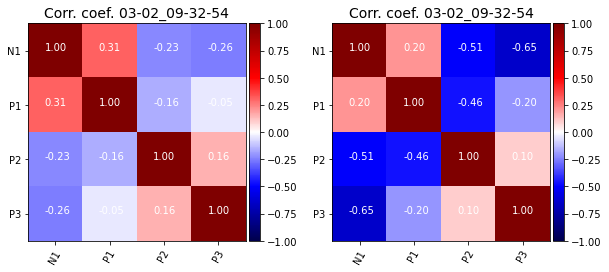

In [33]:
fig = plt.figure(figsize=(10, 4))

titles = ['RAW', 'Z-SMOOTH']
for i, corr_pearson in enumerate([corr_pearson_raw, corr_pearson_norm]):
    ax = fig.add_subplot(1, 2, i+1)
    im = ax.imshow(corr_pearson, cmap='seismic', vmin=-1)
    ax.set_xticks(range(corr_pearson.shape[1]))
    ax.set_xticklabels(metric_names, rotation=60)
    ax.set_yticks(range(corr_pearson.shape[0]))
    _ = ax.set_yticklabels(metric_names)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    #ax.set_title('Metric correlations %s' % titles[i], fontsize=14)
    ax.set_title('Corr. coef. %s' % session[-14:], fontsize=14)
    for p in range(corr_pearson.shape[0]):
        for q in range(corr_pearson.shape[1]):
            ax.text(p - 0.2, q, '%.2f' % corr_pearson[p, q], color='white')

## Controls: speed

In [9]:
selected = selected_009266[:]
area = 'A1'
AEP_targets = ['P1', 'N1', 'P2', 'P3']

speed_corr_mx = np.zeros([len(selected), 4])  # change 4 to how many AEP comps.
speed_pval_mx = np.zeros([len(selected), 4])  # change 4 to how many AEP comps.
for i, session in enumerate(selected):
    session_data = load_session_data(session)
    
    tl = session_data['tl']
    areas = session_data['areas']
    aeps = session_data['aeps']
    aeps_events = session_data['aeps_events']
    AEP_metrics_lims = session_data['AEP_metrics_lims']
    AEP_metrics_raw = session_data['AEP_metrics_raw']
    AEP_metrics_norm = session_data['AEP_metrics_norm']
    
    aeps_tl_idxs = []  # idxs to timeline for AEP events
    for event_t in aeps_events[:, 0]:  # AEP event times
        event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
        aeps_tl_idxs.append(event_idx)
    aeps_tl_idxs = np.array(aeps_tl_idxs)
    
    idxs_aeps_bgr = np.where(aeps_events[:, 1] == 1)[0]
    speed_at_aeps = tl[aeps_tl_idxs[idxs_aeps_bgr]][:, 3]

    for j, AEP_target in enumerate(AEP_targets):
        if not AEP_target in AEP_metrics_norm[area]:
            continue
            
        metric_vals = AEP_metrics_norm[area][AEP_target][idxs_aeps_bgr]
        corr, pval = stats.pearsonr(speed_at_aeps, metric_vals)
        
        speed_corr_mx[i, j] = corr
        speed_pval_mx[i, j] = pval
    
    print("%s done" % session)

009266_hippoSIT_2023-04-17_17-04-17 done
009266_hippoSIT_2023-04-18_10-10-37 done
009266_hippoSIT_2023-04-18_17-03-10 done
009266_hippoSIT_2023-04-19_10-33-51 done
009266_hippoSIT_2023-04-20_08-57-39 done
009266_hippoSIT_2023-04-20_15-24-14 done
009266_hippoSIT_2023-04-21_08-43-00 done
009266_hippoSIT_2023-04-21_13-12-31 done
009266_hippoSIT_2023-04-24_10-08-11 done
009266_hippoSIT_2023-04-24_16-56-55 done
009266_hippoSIT_2023-04-26_08-20-17 done
009266_hippoSIT_2023-05-02_12-22-14 done
009266_hippoSIT_2023-05-04_19-47-15 done
009266_hippoSIT_2023-05-22_09-27-22 done
009266_hippoSIT_2023-05-23_09-18-05 done
009266_hippoSIT_2023-05-25_15-55-57 done
009266_hippoSIT_2023-06-14_08-21-23 done
009266_hippoSIT_2023-06-19_08-58-35 done


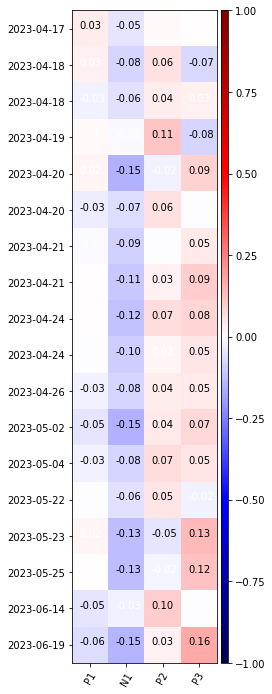

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 12))

im = ax.imshow(speed_corr_mx, cmap='seismic', vmin=-1, vmax=1)
ax.set_xticks(range(speed_corr_mx.shape[1]))
ax.set_xticklabels(AEP_targets, rotation=60)
ax.set_yticks(range(speed_corr_mx.shape[0]))
_ = ax.set_yticklabels([x[-19:-9] for x in selected])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
#ax.set_title('Metric correlations %s' % titles[i], fontsize=14)
#ax.set_title('Corr. coef. %s' % session[-14:], fontsize=14)
for p in range(speed_corr_mx.shape[0]):
    for q in range(speed_corr_mx.shape[1]):
        color = 'white' if speed_pval_mx[p, q] > 0.05 else 'black'
        ax.text(q - 0.3, p, '%.2f' % speed_corr_mx[p, q], color=color)

## N1, P1, N2 stats inside / outside the island

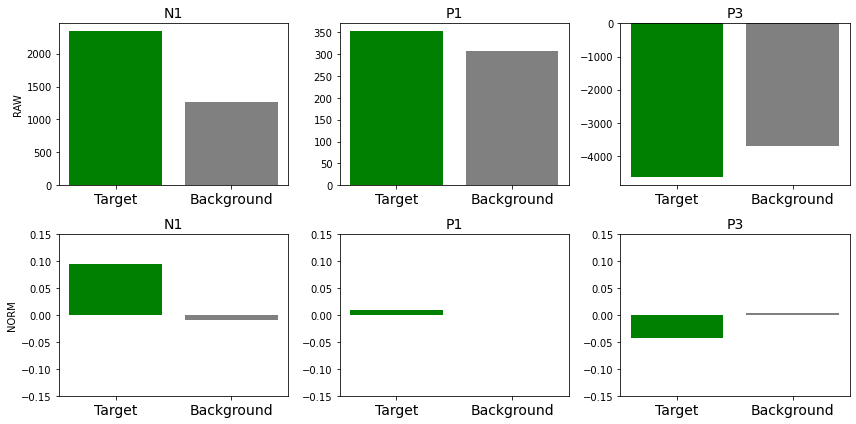

In [30]:
idxs_inside  = np.where(aeps_events[:, 1] == 2)[0]
idxs_outside = np.where(aeps_events[:, 1] == 1)[0]

fig, axes = plt.subplots(2, len(AEP_metrics_lims), figsize=(12, 6))
titles = ['RAW', 'NORM']

for j, metrics in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for i, data in enumerate(metrics.values()):
        d_inside  = data[idxs_inside].mean()
        d_outside = data[idxs_outside].mean()
        axes[j, i].bar([1, 2], [d_inside, d_outside], color=('green', 'grey'))
        axes[j, i].set_xticks([1, 2])  # set correct ticks and labels
        axes[j, i].set_xticklabels(['Target', 'Background'], fontsize=14)
        axes[j, i].set_title(list(AEP_metrics_lims.keys())[i], fontsize=14)

        if i == 0:
            axes[j, i].set_ylabel(titles[j])
            
        if j > 0:
            axes[j, i].set_ylim(-0.15, 0.15)
fig.tight_layout()

## Metric correlations - scatter

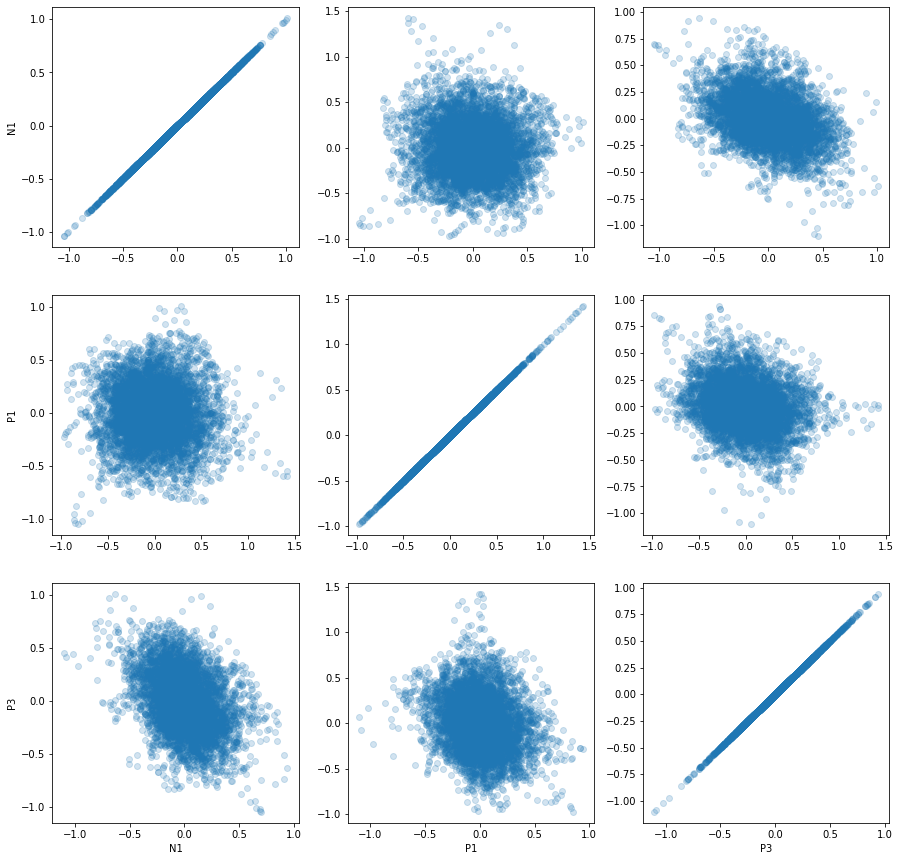

In [20]:
dim = len(AEP_metrics_raw)
fig, axes = plt.subplots(dim, dim, figsize=(15, 15))
for i, (m1_name, m1) in enumerate(AEP_metrics_norm.items()):
    for j, (m2_name, m2) in enumerate(AEP_metrics_norm.items()):
        axes[i, j].scatter(m1, m2, alpha=0.2)
        if j == 0:
            axes[i, j].set_ylabel(m1_name)
        if i == dim - 1:
            axes[i, j].set_xlabel(m2_name)

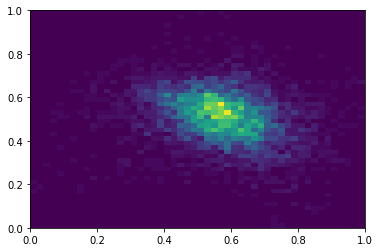

In [33]:
_ = plt.hist2d(AEP_metrics_norm['P1'], AEP_metrics_norm['P2'], bins=50)